# Network Model - Analysis

In [1]:
# Libraries
import numpy as np
from apriori_python import apriori
import pandas as pd
import igraph as ig
import networkx as nx
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from auxiliar_funcs import *
import matplotlib.pyplot as plt
from collections import Counter
from aux_network import build_network_model, bipartite_projection
from aux_plot import calculate_log_binning
from aux_coms import sub_community_detection, add_type_commts
from math import log2, ceil

### Load Data

In [2]:
# Re-order columns by user attributes and resources attributes
user_attr = ['role', 'specialty', 'team', 'uward', 'agentfor']
rsrc_attr = ['type', 'patient', 'treatingteam', 'oward', 'author', 'topic']
print("# User attr:", len(user_attr))
print("# Rsrc attr:", len(rsrc_attr))
print()

##### Load positive access log. #####
url_file = "../00-Data/hc-positive.csv"
df = pd.read_csv(url_file)
df = df[df.columns[:-1]].drop_duplicates()
print("***** POSITIVE HC *****")
print("Columns: ", df.columns)
print("Length: ", len(df))
print(df.info())
print(df.head(5))
print(); print()

##### Load positive access log. #####
url_file = "../00-Data/hc-negative.csv"
df_neg = pd.read_csv(url_file)
df_neg = df_neg[df_neg.columns[:-2]].drop_duplicates()
df_neg = df_neg.replace("?", "none")
df_neg["action"] = 0
print("***** NEGATIVE HC *****")
print("Columns: ", df_neg.columns)
print("Length: ", len(df_neg))
print(df_neg.info())
print(df_neg.head(5))
print(); print()

##### Concatenar solicitudes + y - #####
df_total = pd.concat([df, df_neg])
print("Columns: ", df_total.columns)
print("Length: ", len(df_total))
print()

##### Calcular porcentaje de solicitudes + y - #####
print("% Solicitudes (+): {:.2f}".format((len(df)/len(df_total))*100))
print("% Solicitudes (-): {:.2f}".format((len(df_neg)/len(df_total))*100))
print(); print()

# Cross-Validation
k = 10
test_size = 0.2
kfold = StratifiedShuffleSplit(n_splits=k, test_size=test_size, random_state=1)

data_partition = kfold.split(df_total, df_total.action)
data_corpus = [] # Lista donde se almacenan los k fols

for train_data, test_data in data_partition:        
    X_train, X_test = df_total.iloc[train_data], df_total.iloc[test_data]
    data_corpus.append([X_train, X_test])

print("Hecho!")
print("- k =",k)
print("- Porcentaje Train-Test:", (1-test_size)*100, "-", test_size*100)

print("|U|:", len(df[user_attr].drop_duplicates()))
print("|R|:", len(df[rsrc_attr].drop_duplicates()))

# User attr: 5
# Rsrc attr: 6



***** POSITIVE HC *****
Columns:  Index(['action', 'role', 'type', 'oward', 'uward', 'team', 'treatingteam',
       'patient', 'author', 'topic', 'specialty', 'agentfor'],
      dtype='object')
Length:  8735
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8735 entries, 0 to 8998
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        8735 non-null   int64 
 1   role          8735 non-null   object
 2   type          8735 non-null   object
 3   oward         8735 non-null   object
 4   uward         8735 non-null   object
 5   team          8735 non-null   object
 6   treatingteam  8735 non-null   object
 7   patient       8735 non-null   object
 8   author        8735 non-null   object
 9   topic         8735 non-null   object
 10  specialty     8735 non-null   object
 11  agentfor      8735 non-null   object
dtypes: int64(1), object(11)
memory usage: 887.1+ KB
None
   action    role type    oward    uwar

### Data Pre-processing

In [3]:
id_kfold = 0

df_train_k, df_test_k = data_corpus[id_kfold][0], data_corpus[id_kfold][1]
print("# Solicitudes Train:", len(df_train_k), " %: {:.2f}".format((len(df_train_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Solicitudes Test:", len(df_test_k), " %: {:.2f}".format((len(df_test_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Solicitudes:", len(df_train_k)+len(df_test_k))
print()

n_rsrcs = len(df_train_k[rsrc_attr].drop_duplicates())

##### ***** TAREA 1: Tratar valores desconocidos y nulos ***** #####
print("Tarea 1: Tratar valores desconocidos y nulos.")
# Cambiar valores string a numeros
mapping = {"none": 10, "doctor": 11, "nurse": 12} # role
df_train_k["role"] = df_train_k["role"].replace(mapping)
df_test_k["role"] = df_test_k["role"].replace(mapping)

mapping = {"note": 110, "cardiology": 111, "nursing": 112, "oncology": 113, "none": 114} # speacialty
df_train_k["specialty"] = df_train_k["specialty"].replace(mapping)
df_test_k["specialty"] = df_test_k["specialty"].replace(mapping)

mapping = {"oncteam1": 1101, "carteam1": 1111,
           "carteam2": 1121, "oncteam2": 1131, "none": 1141} # tem
df_train_k["team"] = df_train_k["team"].replace(mapping)
df_test_k["team"] = df_test_k["team"].replace(mapping)

mapping = {"carward": 11011, "oncward": 11111, "none": 11211} # uward
df_train_k["uward"] = df_train_k["uward"].replace(mapping)
df_test_k["uward"] = df_test_k["uward"].replace(mapping)

mapping = {"oncpat1": 111011, "carpat1": 111111, # agentfor
           "oncpat2": 111211, "carpat2": 111311, "none": 111411}
df_train_k["agentfor"] = df_train_k["agentfor"].replace(mapping)
df_test_k["agentfor"] = df_test_k["agentfor"].replace(mapping)

mapping = {"hr": 1110111, "hritem": 1111111} # type
df_train_k["type"] = df_train_k["type"].replace(mapping)
df_test_k["type"] = df_test_k["type"].replace(mapping)

mapping = {"oncpat1": 211012, "carpat1": 211112, # patient
           "oncpat2": 211212, "carpat2": 211312, "none": 211412}
df_train_k["patient"] = df_train_k["patient"].replace(mapping)
df_test_k["patient"] = df_test_k["patient"].replace(mapping)

mapping = {"oncteam1": 2102, "carteam1": 2112,
           "carteam2": 2122, "oncteam2": 2132, "none": 2142} # treatingteam
df_train_k["treatingteam"] = df_train_k["treatingteam"].replace(mapping)
df_test_k["treatingteam"] = df_test_k["treatingteam"].replace(mapping)

mapping = {"carward": 21012, "oncward": 21112, "none": 21212} # oward
df_train_k["oward"] = df_train_k["oward"].replace(mapping)
df_test_k["oward"] = df_test_k["oward"].replace(mapping)

mapping = {"note": 210, "cardiology": 211, "nursing": 212, "oncology": 213, "none": 214} # topic
df_train_k["topic"] = df_train_k["topic"].replace(mapping)
df_test_k["topic"] = df_test_k["topic"].replace(mapping)

mapping = {"oncdoc2": 11110111, "carnurse1": 11111111, "oncnurse2": 11112111, # author
           "carnurse2": 11113111, "oncdoc1": 11114111, "oncnurse1": 11115111, "none": 11116111}
df_train_k["author"] = df_train_k["author"].replace(mapping)
df_test_k["author"] = df_test_k["author"].replace(mapping)
print("Tarea 1: Hecha!.")
print()

##### ***** TAREA 2: Convertir valores continuas a categoricos ***** #####
print("Tarea 2: No aplica!.")
print()

##### ***** TAREA 3: Eliminar solicitudes duplicadas ***** #####
##### Dataframe solicitudes positivas y negativas #####
print("Tarea 3: Eliminar solicitudes duplicadas.")
df_train_k_pos = df_train_k[df_train_k.action==1]   # Train Pos
df_train_k_neg = df_train_k[df_train_k.action==0]   # Train Neg
df_test_k_pos = df_test_k[df_test_k.action==1]      # Test Pos
df_test_k_neg = df_test_k[df_test_k.action==0]      # Test Neg
df_train_k_pos = df_train_k_pos[df_train_k_pos.columns[1:]].drop_duplicates()
df_train_k_neg = df_train_k_neg[df_train_k_neg.columns[1:]].drop_duplicates()
df_test_k_pos = df_test_k_pos[df_test_k_pos.columns[1:]].drop_duplicates()
df_test_k_neg = df_test_k_neg[df_test_k_neg.columns[1:]].drop_duplicates()
print()

##### Agregar la columna de usuarios y recursos #####
user_dict = get_user_res(df_train_k_pos, user_attr, True)
res_dict = get_user_res(df_train_k_pos, rsrc_attr, False)
df_train_k_pos = add_col(df_train_k_pos, user_dict, user_attr, "USRID")
df_train_k_pos = add_col(df_train_k_pos, res_dict, rsrc_attr, "RESID")
df_train_k_neg = add_col(df_train_k_neg, user_dict, user_attr, "USRID")
df_train_k_neg = add_col(df_train_k_neg, res_dict, rsrc_attr, "RESID")
df_test_k_pos =  add_col(df_test_k_pos, user_dict, user_attr, "USRID")
df_test_k_pos =  add_col(df_test_k_pos, res_dict, user_attr, "RESID")
df_test_k_neg = add_col(df_test_k_neg, user_dict, user_attr, "USRID")
df_test_k_neg = add_col(df_test_k_neg, res_dict, rsrc_attr, "RESID")

print("# Solicitudes Train (+):", len(df_train_k_pos), " %: {:.2f}".format((len(df_train_k_pos)/len(df_train_k))*100))
print("# Solicitudes Train (-):", len(df_train_k_neg), " %: {:.2f}".format((len(df_train_k_neg)/len(df_train_k))*100))
print("# Solicitudes Test (+):", len(df_test_k_pos), " %: {:.2f}".format((len(df_test_k_pos)/len(df_test_k))*100))
print("# Solicitudes Test (-):", len(df_test_k_neg), " %: {:.2f}".format((len(df_test_k_neg)/len(df_test_k))*100))
print("# Train Users (+): ", len(df_train_k_pos.USRID.drop_duplicates()))
print("# Train Resrc (+): ", len(df_train_k_pos.RESID.drop_duplicates()))
print("# Train Users (-): ", len(df_train_k_neg.USRID.drop_duplicates()))
print("# Train Resrc (-): ", len(df_train_k_neg.RESID.drop_duplicates()))
print("# Test Users (+): ", len(df_test_k_pos.USRID.drop_duplicates()))
print("# Test Resrc (+): ", len(df_test_k_pos.RESID.drop_duplicates()))
print("# Test Users (-): ", len(df_test_k_neg.USRID.drop_duplicates()))
print("# Test Resrc (-): ", len(df_test_k_neg.RESID.drop_duplicates()))

task4 = True
if task4:
    # Filter resources
    n1 = 0
    n2 = 210
    top_list = df_train_k_pos.RESID.value_counts()[:n_rsrcs].index.tolist()
    # Filter the interval between n1 and n2
    top_list = top_list[n1:n2+1]
    print('#Filtered resources:', len(top_list))

    # B_II Data splitting
    boolean_series = df_train_k_pos.RESID.isin(top_list)
    df_train_k_pos = df_train_k_pos[boolean_series]
    bolean_series = df_train_k_neg.RESID.isin(top_list)
    df_train_k_neg = df_train_k_neg[bolean_series]



# Solicitudes Train: 14186  %: 80.00
# Solicitudes Test: 3547  %: 20.00
# Solicitudes: 17733

Tarea 1: Tratar valores desconocidos y nulos.


c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Tarea 1: Hecha!.

Tarea 2: No aplica!.

Tarea 3: Eliminar solicitudes duplicadas.

# Solicitudes Train (+): 6988  %: 49.26
# Solicitudes Train (-): 7197  %: 50.73
# Solicitudes Test (+): 1747  %: 49.25
# Solicitudes Test (-): 1800  %: 50.75
# Train Users (+):  1046
# Train Resrc (+):  2090
# Train Users (-):  1045
# Train Resrc (-):  1239
# Test Users (+):  748
# Test Resrc (+):  1
# Test Users (-):  826
# Test Resrc (-):  407
#Filtered resources: 211


### Network Modelling

In [4]:
bip_network = build_network_model(df_train_k_pos, 'USRID', 'RESID')

IGRAPH UN-- 823 2340 -- 
+ attr: name (v)
ARBN builded!
IGRAPH UN-- 823 2340 -- 
+ attr: name (v), typen (v)
|U-Nodes| = 612
|R-Nodes| = 211


### User network

In [5]:
user_network = bipartite_projection(bip_network, 0)
print(user_network.summary())
# ig.write(user_network, "graphs/amz_user_network.gml")

IGRAPH UNW- 612 14863 -- 
+ attr: name (v), rsrcs (v), weight (e)


### Network Analysis

In [9]:
# Add features
user_data_attrs = df_train_k_pos[user_attr+["USRID"]].drop_duplicates()
#user_data_attrs[user_data_attrs.USRID == 101]
role_attr = []
specialty_attr = []
team_attr = []
uward_attr = []
agentfor_attr = []
for user in user_network.vs():
    user_row = user_data_attrs[user_data_attrs.USRID == user['name']]    
    role_attr.append(user_row['role'].values[0])
    specialty_attr.append(user_row['specialty'].values[0])
    team_attr.append(user_row['team'].values[0])
    uward_attr.append(user_row['uward'].values[0])
    agentfor_attr.append(user_row['agentfor'].values[0])
    
user_network.vs['role'] = role_attr
user_network.vs['specialty'] = specialty_attr
user_network.vs['team'] = team_attr
user_network.vs['uward'] = uward_attr
user_network.vs['agentfor'] = agentfor_attr
user_network.summary()

'IGRAPH UNW- 612 14863 -- \n+ attr: agentfor (v), name (v), role (v), specialty (v), team (v), uward (v), weight (e)'

In [10]:
density = user_network.density()
print("Density:", "{:.4f}".format(density))

avg_degree = sum(user_network.degree()) / user_network.vcount()
print("Avg. degree", "{:.4f}".format(avg_degree))

components = user_network.components()
print("Connected Components:", len(components))

cc = user_network.transitivity_avglocal_undirected()
print("Clustering Coefficient:", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("Average Path Length :", "{:.4f}".format(L))

Density: 0.0795
Avg. degree 48.5719
Connected Components: 1
Clustering Coefficient: 0.6317
Average Path Length : 2.3571


In [12]:
def calculate_log_binning(degrees_list, n_bins):
    """
    Compute the log-binning y-values.
    """
    current_sum = 0
    previous_k = 0
    y_values_log_bin_list = []
    x_values = []

    for i in range(1, n_bins):
        x_values.append(previous_k)
        current_k = 2 ** (i)
        current_sum = current_sum + current_k
        temp_y_value = sum(degrees_list[previous_k:current_k])
        temp_y_value = temp_y_value / (current_k-previous_k)
        y_values_log_bin_list.append(temp_y_value)
        previous_k = current_k

        if current_sum > len(degrees_list):
            x_values.append(previous_k)
            temp_y_value = sum(degrees_list[previous_k:len(degrees_list)])
            temp_y_value = temp_y_value / (len(degrees_list)-previous_k)
            y_values_log_bin_list.append(temp_y_value)            
            break

    return x_values, y_values_log_bin_list

214


<Figure size 432x288 with 0 Axes>

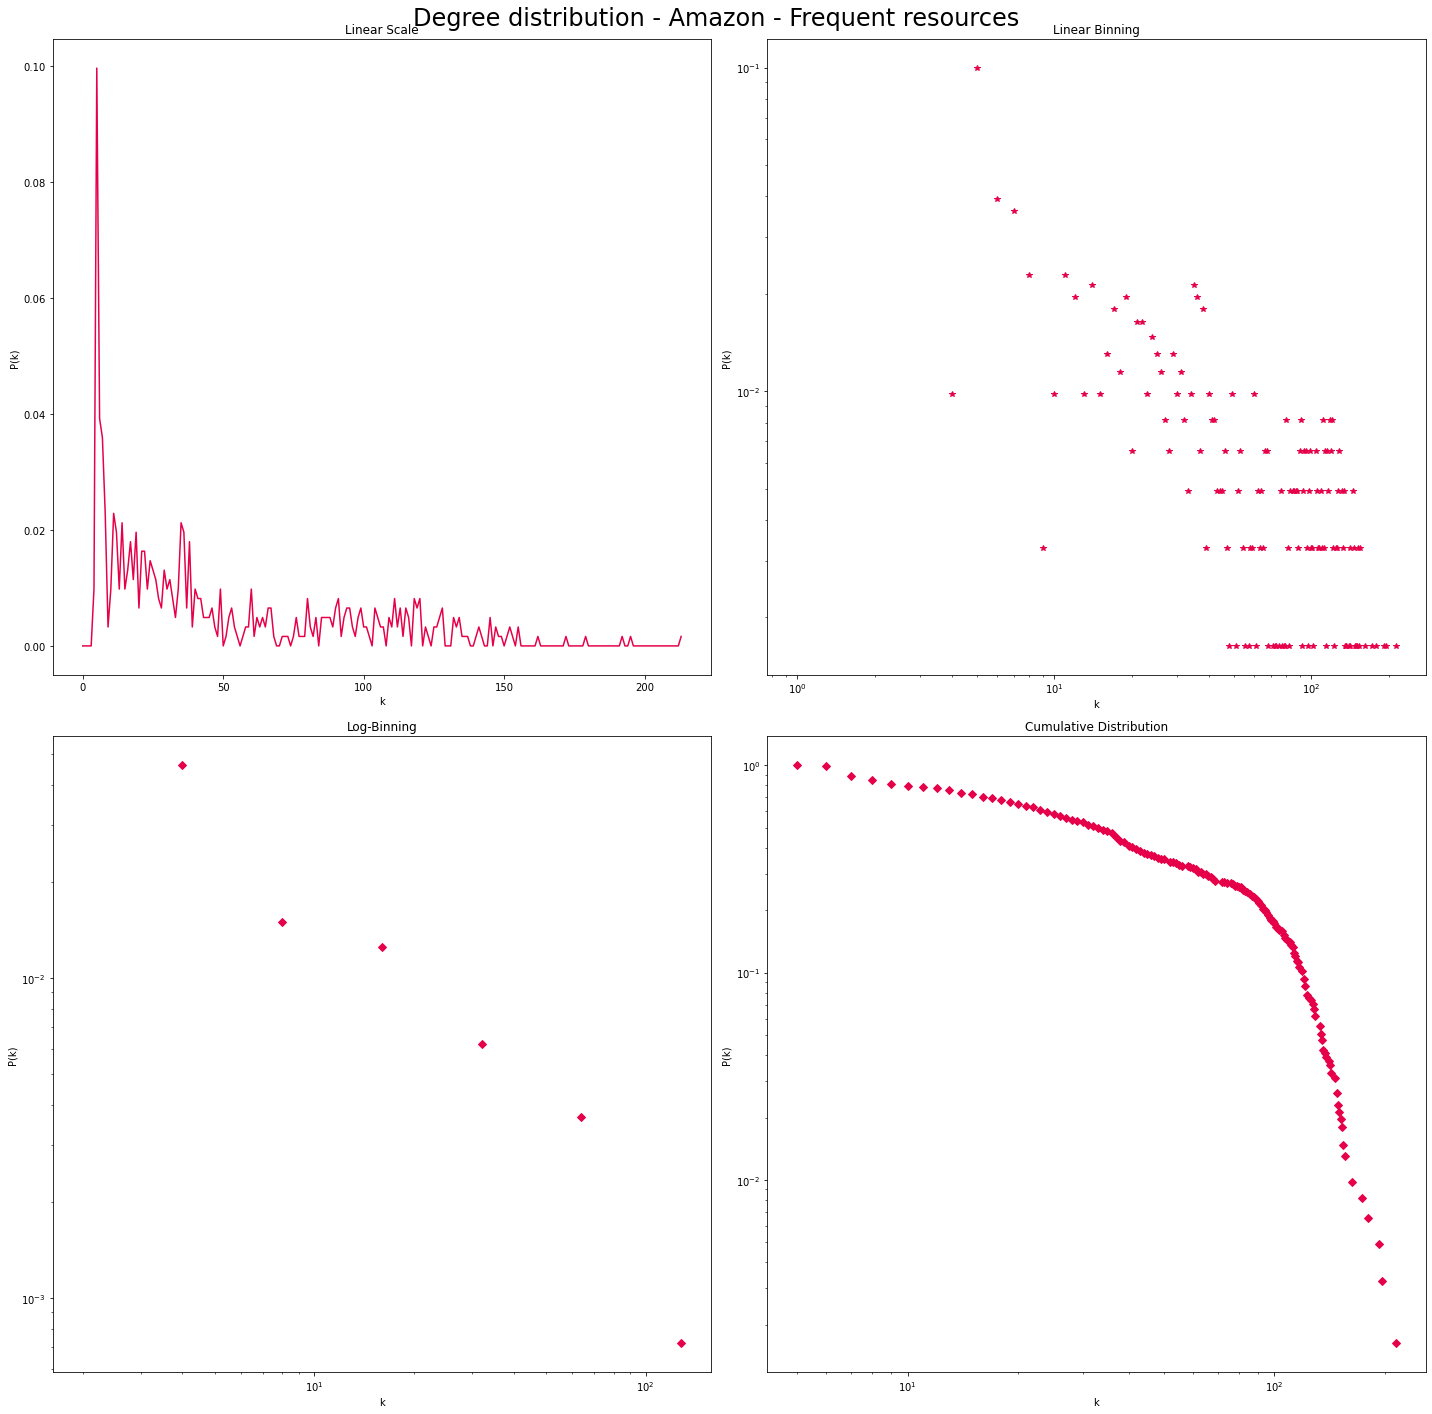

In [13]:
max_degree = max(user_network.degree())
print(max_degree)

# Crear una lista donde se almacena
degree_list = np.zeros(max_degree, dtype=int)

for node in user_network.vs():    
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / user_network.vcount()

plt.clf()
fig, axs = plt.subplots(2, 2, figsize=(20,20))

# LINEAR SCALE
axs[0, 0].set_title('Linear Scale')
axs[0, 0].plot(degree_list, color='#e60049')
axs[0, 0].set(ylabel='P(k)', xlabel='k')

# LINEAR BINNING
axs[0, 1].set_title('Linear Binning')
axs[0, 1].plot(range(max_degree), degree_list, color="#e60049", marker='*', ls='None')
axs[0, 1].loglog()
axs[0, 1].set(ylabel='P(k)', xlabel='k')

# LOG-BINNING
axs[1, 0].set_title('Log-Binning')
n_log_bin = ceil(log2(max(user_network.degree())))
x_values, y_values = calculate_log_binning(degree_list, n_log_bin)
axs[1, 0].plot(x_values, y_values, color='#e60049', marker="D", ls='None')
axs[1, 0].loglog()
axs[1, 0].set(ylabel='P(k)', xlabel='k')

# COMULATIVE
axs[1, 1].set_title("Cumulative Distribution")
degree_sequence = sorted([d for d in user_network.degree()], reverse=True)  # degree sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(np.array(cnt)/user_network.vcount())
axs[1, 1].loglog(deg, cs, color='#e60049', marker="D", ls='None')
axs[1, 1].set(ylabel='P(k)', xlabel='k')

fig.suptitle("Degree distribution - Amazon - Frequent resources", fontsize=24)
fig.tight_layout()
plt.show()

### Weighted distribution

1000


<Figure size 432x288 with 0 Axes>

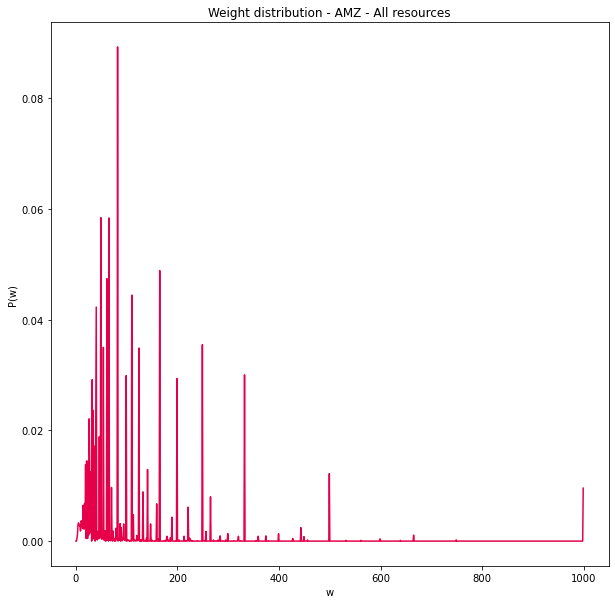

In [15]:
arreglo_test = (np.array(user_network.es['weight'])*1000).astype(int)
max_peso = max(arreglo_test)
print(max_peso)

# Crear una lista donde se almacena
arreglo_test_ = np.zeros(max_peso, dtype=int)

for node in arreglo_test:
    arreglo_test_[node-1] = (arreglo_test_[node-1] + 1)

arreglo_test_ = arreglo_test_ / user_network.ecount()

plt.clf()
plt.figure(figsize=(10,10))
plt.plot(arreglo_test_, color="#e60049")
plt.title("Weight distribution - AMZ - All resources")
plt.xlabel("w")
plt.ylabel("P(w)")
#plt.loglog()
plt.show()

In [21]:
user_network_test = user_network.copy()
user_network_test.es.select(weight_lt=0.4).delete()

In [ ]:
density = user_network_test.density()
print("Density:", density)

avg_degree = sum(user_network_test.degree()) / user_network_test.vcount()
print("Avg. degree", avg_degree)

components = user_network_test.components()
print("Connected Components:", len(components))

### Calculete changes of densities

In [32]:
densitites_list = [user_network.density()] # Store all densities values
thresholds_list = np.linspace(0, 1, num=11)[1:-1] # nine values

for thrs in thresholds_list:
    current_user_net = user_network.copy() # Create a copy of user network
    
    # Remove edges less than current threshold
    current_user_net.es.select(weight_lt=thrs).delete()
    
    current_density = current_user_net.density() # Compute density
    
    # Store current density in the density list
    densitites_list.append(current_density)

# Show densities
print(densitites_list)

[0.022874443231497874, 0.009990839019907624, 0.005340227964554199, 0.003177833267323172, 0.0022572399424410318, 0.002229144219662889, 0.0008576589058590997, 0.0008370455176734518, 0.0008365427521079481, 0.0008364540287728594]


<Figure size 432x288 with 0 Axes>

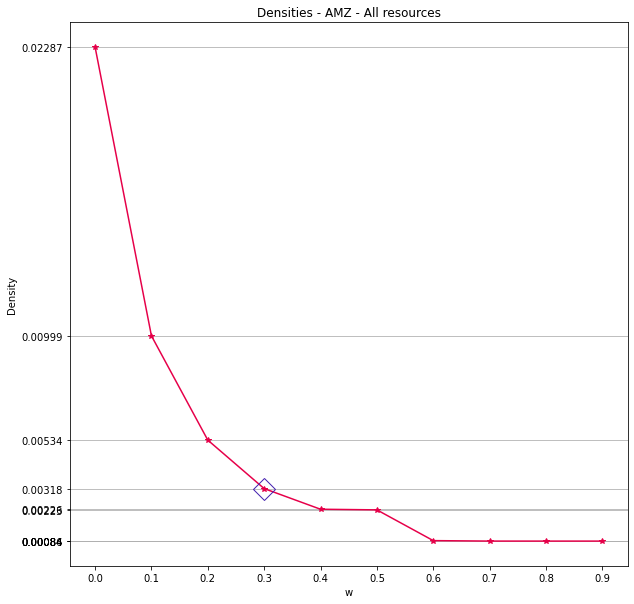

In [61]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot([0]+list(thresholds_list), densitites_list, color="#e60049", marker='*')
plt.title("Densities - AMZ - All resources")
plt.xlabel("w")
plt.xticks([0]+list(thresholds_list))
plt.ylabel("Density")
plt.yticks(densitites_list)
plt.grid(axis='y')
plt.plot(0.3, densitites_list[3], marker="D", markersize=15, fillstyle='none', color="#4421af")
#plt.loglog()
plt.show()

### Components Analysis

In [16]:
# Shows the size counter of the components
dict_compoenents = dict(Counter(components.sizes()))
print(dict_compoenents)

{612: 1}


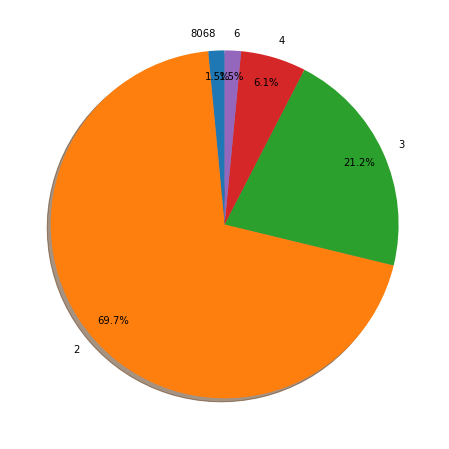

In [56]:
fig, ax = plt.subplots(figsize=(8,))
ax.pie(dict_compoenents.values(), labels=dict_compoenents.keys(), 
       autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=.85)
plt.show()

In [117]:
### Compute the % of nodes in the huge component

# In this case, we have huge component in index=0
huge_component = components.subgraph(0)
print("HugeComp Nodes:", huge_component.vcount())
print("HugeComp Edges:", huge_component.ecount())

# We recall how many user there
n_users_bip = user_network.vcount()
print("|Nodes| =", n_users_bip)

# % of nodes in the huge component
pct_users_huge = huge_component.vcount() / n_users_bip
print("Pct of nodes: {:.2f}%".format(pct_users_huge*100))

# % of links in the huge component 
n_res_bip = user_network.ecount()
print("|Edges| =", n_res_bip)
pct_res_huge = huge_component.ecount() / n_res_bip
print("Pct of edges: {:.2f}%".format(pct_res_huge*100))

HugeComp Nodes: 8068
HugeComp Edges: 773338
|Nodes| = 8224
Pct of nodes: 98.10%
|Edges| = 773453
Pct of edges: 99.99%


In [166]:
### Compute the resources in the components.

counter_res = [] # Save all resources 
counter_res_huge = [] # Save resources in huge component

for compnt in components.subgraphs(): # Omit the huge component
    # Get node users
    users_comp = list(compnt.vs())    
    
    rsrc_in_components = [] # Store "name" attribute of resources

    # Loop over user nodes
    for i_node in users_comp:
        # Search the node in the bipartite network by its name
        i_query = bip_network.vs.find(name=i_node["name"])

        # Get the resources (neighbors) of i_node
        neighs_inodes = bip_network.neighbors(i_query)
        
        # loop over the resources
        for i_rsrc in neighs_inodes:
            # Adding to list
            rsrc_in_components.append(bip_network.vs(i_rsrc)[0]["name"])

    # Remove duplicate values
    rsrc_in_components = list(set(rsrc_in_components))
    
    if len(users_comp) == 8068: # The huge component
        counter_res_huge += rsrc_in_components
    else:
        counter_res += rsrc_in_components # Global resources in small components

# Remove duplicate values
counter_res = list(set(counter_res))
print(len(counter_res), counter_res)

counter_res_huge = list(set(counter_res_huge))
print(len(counter_res_huge), counter_res_huge)

117 [74241, 73741, 36885, 78882, 75815, 89134, 35374, 80947, 73783, 84024, 74297, 79936, 6723, 77390, 34895, 31834, 78429, 78435, 78436, 16997, 36971, 99949, 74874, 100475, 36476, 77946, 74367, 77951, 74369, 27786, 74896, 32401, 74899, 30868, 80021, 79000, 25753, 43165, 27309, 31921, 31922, 74930, 45236, 45237, 73907, 35000, 109753, 71866, 16570, 39612, 31936, 36036, 6855, 716, 79566, 74447, 28370, 42709, 19678, 6878, 74982, 78570, 37115, 27901, 43265, 20744, 39695, 75032, 79640, 78108, 34076, 78111, 40753, 25407, 27970, 26436, 15697, 43860, 56665, 33115, 78178, 37221, 37222, 43879, 26985, 30573, 74610, 73075, 28532, 36724, 74614, 78713, 35716, 28550, 35722, 43915, 45451, 42382, 42383, 37781, 28568, 36772, 75685, 23461, 77225, 44975, 41399, 42945, 70088, 42967, 41433, 32223, 35819, 45044, 74743, 34300, 105470]
5944 [0, 38, 98430, 98431, 98437, 138, 153, 98494, 98500, 199, 203, 216, 32985, 32986, 32987, 32997, 33001, 33002, 233, 237, 98547, 33012, 98552, 256, 33031, 33032, 33033, 33035,

In [168]:
### Number of resources in each component
# Total of resources
total_counter_res = counter_res + counter_res_huge

# Remove duplicate values
total_counter_res = list(set(total_counter_res))

# % of resources in small components of all
pct_res = (len(counter_res) / len(total_counter_res))*100
print("Pct of resources (SMALL): {:.2f}% - ({} / {})".format(pct_res,
                                                             len(counter_res),
                                                             len(total_counter_res)))

# % of resources in small components of all
pct_res = (len(counter_res_huge) / len(total_counter_res))*100
print("Pct of resources (HUGE): {:.2f}% - ({} / {})".format(pct_res, 
                                                            len(counter_res_huge),
                                                            len(total_counter_res)))

Pct of resources (SMALL): 1.93% - (117 / 6061)
Pct of resources (HUGE): 98.07% - (5944 / 6061)


In [171]:
### Importance of resources in each component

dict_freq_res = {} # Save counter access

for i_res in counter_res: # Small components
    # Number of accesss requests in Dataframe
    dict_freq_res[i_res] = len(df_train_k_pos[df_train_k_pos.RESOURCE==i_res])

print("MAX access in a resource (SMALL):", max(dict_freq_res.values()))

for i_res in counter_res_huge: # Small components
    # Number of accesss requests in Dataframe
    dict_freq_res[i_res] = len(df_train_k_pos[df_train_k_pos.RESOURCE==i_res])

print("MAX access in a resource (HUGE):", max(dict_freq_res.values()))

MAX access in a resource (SMALL): 5
MAX access in a resource (HUGE): 671


In [181]:
### Analysis all networks vs huge compoenent

density = user_network.density()
print("Density (ALL):", "{:.4f}".format(density))
density = huge_component.density()
print("Density (HUGE):", "{:.4f}".format(density))

avg_degree = sum(user_network.degree()) / user_network.vcount()
print("Avg. degree (ALL)", "{:.4f}".format(avg_degree))
avg_degree = sum(huge_component.degree()) / huge_component.vcount()
print("Avg. degree (HUGE)", "{:.4f}".format(avg_degree))

components = user_network.components()
print("Connected Components (ALL):", len(components))
components = huge_component.components()
print("Connected Components (HUGE):", len(components))

cc = user_network.transitivity_avglocal_undirected()
print("Clustering Coefficient (ALL):", "{:.4f}".format(cc))
cc = huge_component.transitivity_avglocal_undirected()
print("Clustering Coefficient: (HUGE)", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("Average Path Length (ALL):", "{:.4f}".format(L))
L = huge_component.average_path_length()
print("Average Path Length (HUGE):", "{:.4f}".format(L))

Density (ALL): 0.0229
Density (HUGE): 0.0238
Avg. degree (ALL) 188.0965
Avg. degree (HUGE) 191.7050
Connected Components (ALL): 66
Connected Components (HUGE): 1
Clustering Coefficient (ALL): 0.7931
Clustering Coefficient: (HUGE) 0.7924
Average Path Length (ALL): 2.8750
Average Path Length (HUGE): 2.8750


### Community Analysis

In [6]:
### Community detection algorithm

# Louvain Algorithm
partition = user_network.community_multilevel(weights=user_network.es()["weight"])
print("Modularity: %.4f" % partition.modularity) # Modualarity value

# Add cluster attribute to nodes
user_network.vs["commty"] = partition.membership

print(user_network.summary())
print(partition.summary())

Modularity: 0.4624
IGRAPH UNW- 612 14863 -- 
+ attr: commty (v), name (v), rsrcs (v), weight (e)
Clustering with 612 elements and 13 clusters


In [7]:
dict_commts = sub_community_detection(user_network, partition, 0.5)
len(dict_commts)

41

In [8]:
# Obtener el máximo valor de recursos en el total de comunidades
n_res_in_comms = [len(i[1]) for i in dict_commts.values()]
max_n_res = max(n_res_in_comms)
print("Comunidad con # mayor recursos", max_n_res)

# Umbrales para la clasificación de comunidades
big_threshold = int(0.50 * max_n_res)
med_threshold = int(0.25 * max_n_res)
print("Big Threshold: ", big_threshold, " \t\t Med Threshold", med_threshold)

Comunidad con # mayor recursos 98
Big Threshold:  49  		 Med Threshold 24


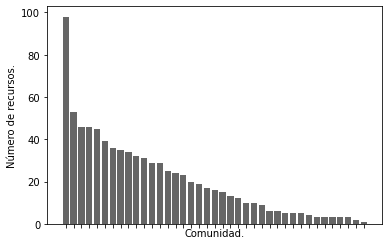

In [13]:
plt.bar(dict_commts.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz.pdf')

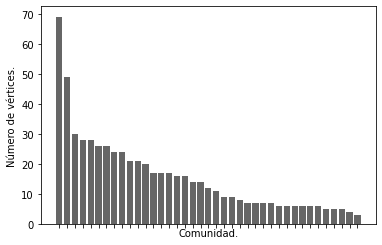

In [14]:
lista_tamano_coms = []
for i in dict_commts:
    lista_tamano_coms.append(dict_commts[i][0].vcount())
    #print(dict_total_coms[i][0].vcount())
len(lista_tamano_coms)

# plt.figure(figsize=(20,15))
plt.bar(dict_commts.keys(), sorted(lista_tamano_coms, reverse=True), color='0.40')
plt.ylabel('Número de vértices.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_vertices_por_comunidad_amz.pdf')

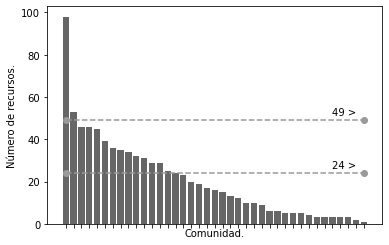

In [15]:
# plt.figure(figsize=(20,15))
plt.bar(dict_commts.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
x, y = [0, len(n_res_in_comms)-1] , [big_threshold, big_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, big_threshold+6, '{} >'.format(big_threshold) , ha='left', va= 'top')
x, y = [0, len(n_res_in_comms)-1] , [med_threshold, med_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, med_threshold+6, '{} >'.format(med_threshold) , ha='left', va= 'top')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz-corte.pdf')

In [9]:
def agregar_tipo_com(grafo, set_users_, tipo):
    for user_ in set_users_:
        vertice = grafo.vs.find(name=user_)
        vertice["tipoCom"] = tipo

In [10]:
big_comms = [] # Almacenar las comunidades grandes
med_comms = [] # Almacenar las comunidades medianas
sma_comms = [] # Almacenar las comunidades pequeñas
user_network.vs["tipoCom"] = -1


for idx_com, com in enumerate(dict_commts.values()):
    if len(com[1]) > big_threshold: # Es comunidad grande
        big_comms.append([idx_com,0]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 0)
    elif len(com[1]) > med_threshold: # Es comunidad mediana
        med_comms.append([idx_com,1]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 1)
    else:
        sma_comms.append([idx_com,2]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 2)

print("# Comunidades:",len(big_comms)+len(med_comms)+len(sma_comms), "==", len(dict_commts))
print("Big Comms:", len(big_comms))
print("Med Comms:", len(med_comms))
print("Sma Comms:", len(sma_comms))

# Comunidades: 41 == 41
Big Comms: 2
Med Comms: 13
Sma Comms: 26


In [11]:
all_commts = sma_comms + med_comms + big_comms
all_commts[0]

[11,
 2,
 [31202, 283202, 1384202, 117202, 17202, 390202]]

In [18]:
th_lfr = 0.2
th_sr = 0.5
dict_ress_coms = {}  # Diccionario de recursos
list_rules = []  # Lista de reglas
dict_res_in_coms = {}  # Diccionarios de recursos en comunidad

for commty_ in all_commts:
    commty_resources = commty_[3] # Get resources
    #print()
    #print("RECURSOS", commty_[3])
    
    if commty_[1] != 2:
        
        commty_resources = frequent_resources(commty_[2], bip_network, th_lfr)
        #print("TIPO 2-3 FREQ:", commty_resources)

        if commty_[1] == 0:            
            commty_significant_res = frequent_resources(commty_[2], bip_network, th_sr)              
            for sig_resource in commty_significant_res:
                #print("\n",sig_resource)
                # Create a rule
                rule_i = [ ["id_com", str(commty_[0])], [] ] # Se comienza generando la regla.
                for attr in rsrc_attr:
                    logs_with_resource = df_train_k_pos[df_train_k_pos["RESID"]==sig_resource].iloc[0]
                    print("*-",[attr, logs_with_resource[attr]])
                    rule_i[1].append([attr, logs_with_resource[attr]])
                
                # Atributos frecuentes en usuarios
                df_users_commty = get_attrs_from_user_sig(commty_[2], df_train_k_pos, user_attr, sig_resource, bip_network)
                rule_user_attrs = attribute_value_common(df_users_commty)
                rule_i[1] = rule_i[1] + rule_user_attrs
                list_rules.append(rule_i)
                
                
            #print("TIPO 3 SIG:", commty_significant_res)    
            commty_resources = [i for i in commty_resources if i not in commty_significant_res]
            #print("TIPO 3 RESTA:", commty_resources)

    # Create the other rule
    rule_i = [ ["id_com", str(commty_[0])], [] ] # Se comienza generando la regla.

    df_res_commty = get_attrs_from_res(df_train_k_pos, rsrc_attr, commty_resources)
    rule_res_attrs = attribute_value_common(df_res_commty)
    rule_i[1] = rule_i[1] + rule_res_attrs

    # Atributos frecuentes en usuarios
    df_users_commty = get_attrs_from_user(commty_[2], df_train_k_pos, user_attr, commty_resources, bip_network)
    rule_user_attrs = attribute_value_common(df_users_commty)
    rule_i[1] = rule_i[1] + rule_user_attrs
    list_rules.append(rule_i)
                
list_rules


['type', 1111111]
['patient', 211212]
['treatingteam', 2112]
['oward', 21212]
['author', 11114111]
['topic', 211]
['type', 1111111]
['patient', 211112]
['treatingteam', 2122]
['oward', 21012]
['author', 11111111]
['topic', 210]


[[['id_com', '11'],
  [['topic', 210],
   ['patient', 211212],
   ['type', 1111111],
   ['uward', 11211],
   ['agentfor', 111211]]],
 [['id_com', '15'],
  [['patient', 211212], ['type', 1111111], ['uward', 11011], ['role', 12]]],
 [['id_com', '17'],
  [['topic', 210],
   ['patient', 211212],
   ['type', 1111111],
   ['uward', 11211],
   ['agentfor', 111211]]],
 [['id_com', '18'],
  [['topic', 212],
   ['oward', 21012],
   ['type', 1111111],
   ['uward', 11011],
   ['role', 12]]],
 [['id_com', '19'],
  [['treatingteam', 2122],
   ['topic', 212],
   ['oward', 21012],
   ['type', 1111111],
   ['uward', 11011],
   ['role', 12]]],
 [['id_com', '20'],
  [['topic', 212],
   ['oward', 21012],
   ['type', 1111111],
   ['uward', 11011],
   ['role', 12]]],
 [['id_com', '21'],
  [['topic', 212],
   ['oward', 21012],
   ['type', 1111111],
   ['uward', 11011],
   ['role', 12]]],
 [['id_com', '22'],
  [['topic', 212],
   ['oward', 21012],
   ['type', 1111111],
   ['uward', 11011],
   ['role', 12]]],


In [13]:
def remove_equal_rulesX(rules):
    rules = [set(r[:-1]) for r in rules]

    a = []
    for r in rules:
        if not r in a:
            a.append(r)

    max_id = 0
    to_ret = None
    for i in a:
        if len(i) > max_id:            
            max_id = len(i)
            to_ret = i    

    return [to_ret]

def frequent_resources(subcomunidad, grafo_bip, umbral):
    """Retorna los recursos nuevos ya podados."""
    usuario_comunidad = subcomunidad.vs()["name"]
    all_recursos = []  # DIccionario con los recursos y su frecuencia
    for user in usuario_comunidad:
        user_node = grafo_bip.vs.find(name=user)
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [node["name"] for node in vecinos_recurso]
        vecinos_recurso = list(set(vecinos_recurso))
        #print(vecinos_recurso)
        all_recursos = all_recursos + vecinos_recurso

    umbral_en_n = int(umbral * subcomunidad.vcount())
    
    all_recursos = dict(Counter(all_recursos))
    
    frequent_resources = [id_res for (id_res, value_) in all_recursos.items() if value_ >= umbral_en_n]
    
    if len(frequent_resources) == 0:
        frequent_resources = [id_res for (id_res, value_) in all_recursos.items() if value_ >= max(all_recursos.values())]    

    return frequent_resources

def get_attrs_from_res(data_, res_attr, resources):    
    df_res_commty = data_[data_["RESID"].isin(resources)]
    df_res_commty = df_res_commty[res_attr+["RESID"]].drop_duplicates()
    
    return df_res_commty

def get_attrs_from_user(commty_network, data_, user_attr, resources, bip_network):
    users_commty = commty_network.vs["name"] 
    df_users_commty = data_[data_["USRID"].isin(users_commty)]
    df_users_commty = data_[data_["RESID"].isin(resources)]
    df_users_commty = df_users_commty[user_attr+["USRID"]].drop_duplicates()
    
    return df_users_commty

def get_attrs_from_user_sig(commty_network, data_, user_attr, sig_resource, bip_network):
    users_commty = commty_network.vs["name"]
    user_access_sig_resource = bip_network.vs.find(name=sig_resource)
    user_access_sig_resource = user_access_sig_resource.neighbors()
    user_access_sig_resource = [node["name"] for node in user_access_sig_resource]
    users_commty = list(set(user_access_sig_resource).intersection(set(users_commty)))
    df_users_commty = data_[data_["USRID"].isin(users_commty)]
    df_users_commty = df_users_commty[user_attr+["USRID"]].drop_duplicates()
    
    return df_users_commty

def get_attr_name_by_value(value, data_):
    #value = list(value)[0]
    for attr in data_.columns:
        if value in list(data_[attr].drop_duplicates()):
            return attr
    return None

def attribute_value_common(data_):
    """Retorna regla apriori basada en los recursos.
    data_: dataframe
    """
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []    
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(data_.values.tolist(), minSup=init_Sup,
                           minConf=init_Conf)  # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1        
        
    #print(rules)
    rules = [list(r[0])+list(r[1])+[r[-1]] for r in rules]
    rules = remove_equal_rulesX(rules)    
    rules = [list(r) for r in rules]
    #print(rules)
    

    reglas_karimi = []
    for r in rules:
        for t in r:
            col = get_attr_name_by_value(t, data_)
            reglas_karimi.append([col, t])

    return reglas_karimi

In [15]:
test = [[0, 1, 2, 3],
[0, 1, 2, 4],
[0, 1, 2, 5],
[0, 1, 2, 6],
[0, 1, 2, 7],
[1, 2, 8, 0],
[1, 9, 8, 0],
[9, 1, 2, 0]]

In [18]:
init_Sup = 0.6
init_Conf = 0.9
_, rules = apriori(test, minSup=init_Sup, minConf=init_Conf) # Apply apriori
rules = [list(r[0])+list(r[1])+[r[-1]] for r in rules]
rules

[[0, 1, 1.0],
 [1, 0, 1.0],
 [2, 0, 1.0],
 [2, 1, 1.0],
 [2, 0, 1, 1.0],
 [0, 2, 1, 1.0],
 [1, 2, 0, 1.0]]

In [22]:
rules = [set(r) for r in rules]
rules

[{0, 1}, {0, 1}, {0, 2}, {1, 2}, {0, 1, 2}, {0, 1, 2}, {0, 1, 2}]

In [ ]:
# El de remover las reglas

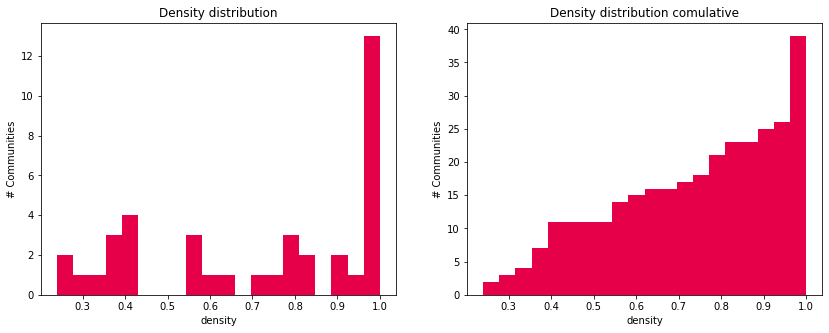

In [20]:
### Density distribution of each community

density_distribution = [] # Store all densities

for comty in sma_comms+med_comms+big_comms: # Loop over all type communities    
    temp_density = comty[1].density() # Graph object [1]
    density_distribution.append(temp_density)

fig, axs = plt.subplots(1, 2, figsize=(14,5))

counts, bins = np.histogram(density_distribution, 20)

# Density distribution
axs[0].set_title('Density distribution')
axs[0].hist(bins[:-1], bins, weights=counts, color="#e60049")
axs[0].set(ylabel='# Communities', xlabel='density')

axs[1].set_title('Density distribution comulative')
axs[1].hist(bins[:-1], bins, weights=counts, color="#e60049", cumulative=True,
            histtype="bar")
axs[1].set(ylabel='# Communities', xlabel='density')

plt.show()


In [24]:
### Resource accessed distribution by communities
# Recorresr todos los recursos y ver los usuarios que acceden al él. Detectar
# de cual tipo de comunidad atrae más usuarios.

all_types_coms = sma_comms + med_comms + big_comms # All types of communitites

 # Store the number of users in each type of community
dict_user_coms = {} # Example -> {id_res: {sma: 40, med: 12, big: 4}, ...}

for rsrc in bip_network.vs.select(typen=1):
    # Get all users "name" which accessed to the rsrc (resource)
    users_name_accessed = [i["name"] for i in rsrc.neighbors()]

    # Counters
    counter_small = 0
    counter_med = 0
    counter_big = 0
    rsr_impor_sma = rsr_impor_med = rsr_impor_big = 0    
    counter_coms = 0
    counter_coms_type_sma = counter_coms_type_med = counter_coms_type_big = 0
    
    # Get all user in small communities
    for comty in sma_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_small += len(intersec_users)
            rsr_impor_sma += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_sma = rsr_impor_sma / counter_coms
        counter_coms_type_sma = counter_coms / len(sma_comms)
    else:
        rsr_impor_sma = 0
        counter_coms_type_sma = 0
    counter_coms = 0

    # Get all user in small communities
    for comty in med_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_med += len(intersec_users)
            rsr_impor_med += len(intersec_users) / len(users_in_com)
            counter_coms += 1
        
    if counter_coms > 0:
        rsr_impor_med = rsr_impor_med / counter_coms
        counter_coms_type_med = counter_coms / len(med_comms)
    else:
        rsr_impor_med = 0
        counter_coms_type_med = 0
    counter_coms = 0

    for comty in big_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_big += len(intersec_users)
            rsr_impor_big += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_big = rsr_impor_big / counter_coms
        counter_coms_type_big = counter_coms / len(big_comms)
    else:
        rsr_impor_big = 0
        counter_coms_type_big = 0
    counter_coms = 0

    
    total_accessed = counter_big + counter_small + counter_med
    total_counter_coms = counter_coms_type_sma + counter_coms_type_med + counter_coms_type_big
    total_rsr_impor = rsr_impor_sma + rsr_impor_med + rsr_impor_big
    # Add all counters
    dict_user_coms[rsrc["name"]] = {"sma": counter_small/total_accessed,
                                     "med": counter_med/total_accessed,
                                     "big":counter_big/total_accessed}
    
#dict_user_coms

In [25]:
a = pd.DataFrame(dict_user_coms)
a = a.T
a["name"] = range(211)
a = a.sort_values("sma", ascending=False)
a.rename(columns = {'sma':'Concentradas', "med": "Medianas", "big":"Dispersas"}, inplace = True)
a

,Concentradas,Medianas,Dispersas,name
438202,1.0,0.000000,0.000000,125
174202,1.0,0.000000,0.000000,61
1052202,1.0,0.000000,0.000000,192
304202,1.0,0.000000,0.000000,94
463202,1.0,0.000000,0.000000,127
...,...,...,...,...
480202,0.0,0.000000,1.000000,132
78202,0.0,0.000000,1.000000,25
467202,0.0,0.000000,1.000000,129
132202,0.0,0.857143,0.142857,47


<Figure size 1440x2160 with 0 Axes>

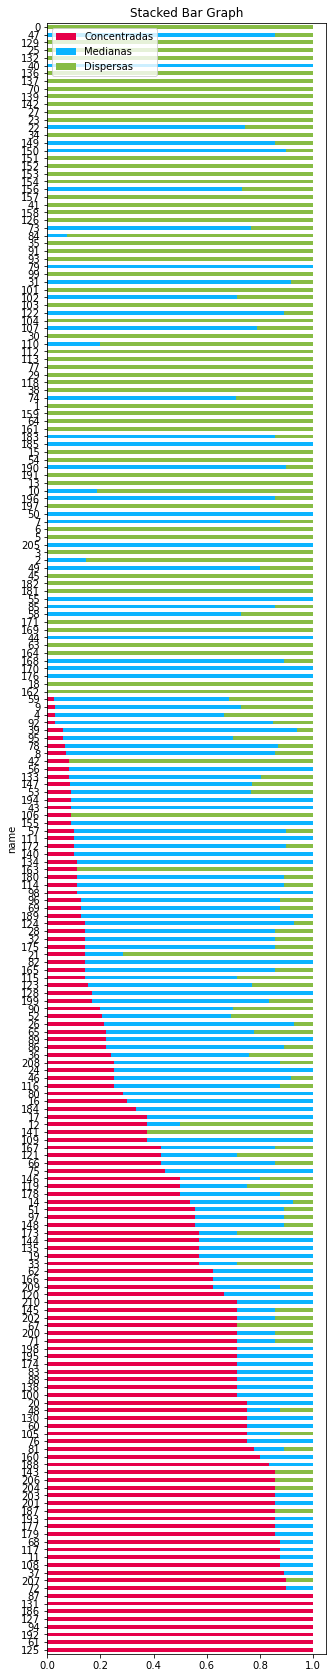

In [26]:
 #plot a Stacked Bar Graph
colors = ['#e60049', '#0bb4ff', '#87bc45']
plt.figure(figsize=(20,30))
a.plot(
    x = "name",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True, figsize=(5,30), color=colors)
plt.show()

In [27]:
### Resource accessed distribution by communities
# Recorresr todos los recursos y ver los usuarios que acceden al él. Detectar
# de cual tipo de comunidad atrae más usuarios.

all_types_coms = sma_comms + med_comms + big_comms # All types of communitites

 # Store the number of users in each type of community
dict_user_coms = {} # Example -> {id_res: {sma: 40, med: 12, big: 4}, ...}

for rsrc in bip_network.vs.select(typen=1):
    # Get all users "name" which accessed to the rsrc (resource)
    users_name_accessed = [i["name"] for i in rsrc.neighbors()]

    # Counters
    counter_small = 0
    counter_med = 0
    counter_big = 0
    counter_coms = 0
    counter_coms_type_sma = counter_coms_type_med = counter_coms_type_big = 0
    
    # Get all user in small communities
    for comty in sma_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_small += len(intersec_users)
            rsr_impor_sma += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        counter_coms_type_sma = counter_coms / len(sma_comms)
    else:
        counter_coms_type_sma = 0
    counter_coms = 0

    # Get all user in small communities
    for comty in med_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_med += len(intersec_users)
            rsr_impor_med += len(intersec_users) / len(users_in_com)
            counter_coms += 1
        
    if counter_coms > 0:
        counter_coms_type_med = counter_coms / len(med_comms)
    else:
        counter_coms_type_med = 0
    counter_coms = 0

    for comty in big_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_big += len(intersec_users)
            rsr_impor_big += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        counter_coms_type_big = counter_coms / len(big_comms)
    else:
        counter_coms_type_big = 0
    counter_coms = 0

    total_accessed = counter_big + counter_small + counter_med


    # Add all counters
    dict_user_coms[rsrc["name"]] = {"impComSma": counter_coms_type_sma,
                                    "impSmaRes": 1-counter_coms_type_sma,
                                     "impComMed": counter_coms_type_med,
                                     "impMedRes": 1-counter_coms_type_med,
                                     "impComBig": counter_coms_type_big,
                                     "impBigRes": 1-counter_coms_type_big,
                                     "sma": counter_small/total_accessed}
    
#dict_user_coms

In [29]:
a = pd.DataFrame(dict_user_coms)
a = a.T
a["name"] = range(211)
a = a.sort_values("sma", ascending=False)
a = a.drop("sma", axis=1)
a.rename(columns = {'impComSma':'Concetradas', "impSmaRes": "Total Conc", "impComMed": "Medianas", "impMedRes": "Total Med", "impComBig":"Dispersas","impBigRes": "Total Med"}, inplace = True)
a

,Concetradas,Total Conc,Medianas,Total Med,Dispersas,Total Med,name
438202,0.24,0.76,0.000000,1.000000,0.0,1.0,125
174202,0.12,0.88,0.000000,1.000000,0.0,1.0,61
1052202,0.08,0.92,0.000000,1.000000,0.0,1.0,192
304202,0.08,0.92,0.000000,1.000000,0.0,1.0,94
463202,0.04,0.96,0.000000,1.000000,0.0,1.0,127
...,...,...,...,...,...,...,...
480202,0.00,1.00,0.000000,1.000000,0.5,0.5,132
78202,0.00,1.00,0.000000,1.000000,0.5,0.5,25
467202,0.00,1.00,0.000000,1.000000,0.5,0.5,129
132202,0.00,1.00,0.166667,0.833333,0.5,0.5,47


<Figure size 1080x2160 with 0 Axes>

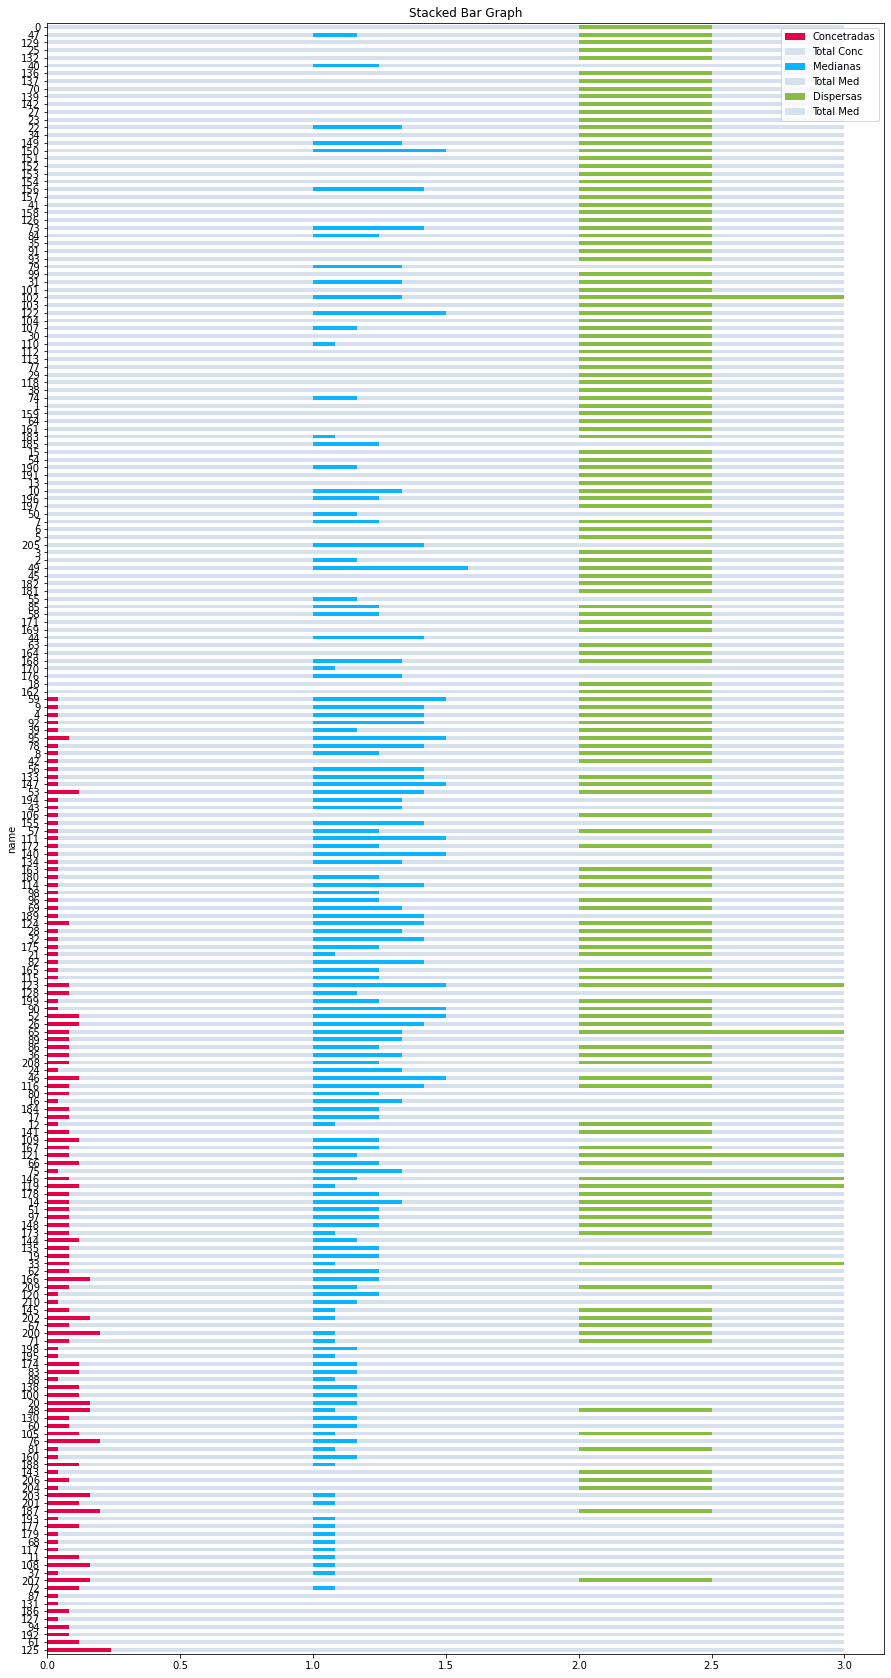

In [30]:
 #plot a Stacked Bar Graph
colors = ['#e60049', '#d7e1ee', '#0bb4ff', '#d7e1ee','#87bc45','#d7e1ee']
plt.figure(figsize=(15,30))
a.plot(
    x = "name",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True, figsize=(15,30), color=colors)
plt.show()

In [31]:
### Resource accessed distribution by communities
# Recorresr todos los recursos y ver los usuarios que acceden al él. Detectar
# de cual tipo de comunidad atrae más usuarios.

all_types_coms = sma_comms + med_comms + big_comms # All types of communitites

 # Store the number of users in each type of community
dict_user_coms = {} # Example -> {id_res: {sma: 40, med: 12, big: 4}, ...}

for rsrc in bip_network.vs.select(typen=1):
    # Get all users "name" which accessed to the rsrc (resource)
    users_name_accessed = [i["name"] for i in rsrc.neighbors()]

    # Counters
    counter_small = 0
    counter_med = 0
    counter_big = 0
    rsr_impor_sma = rsr_impor_med = rsr_impor_big = 0    
    counter_coms = 0
    
    # Get all user in small communities
    for comty in sma_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_small += len(intersec_users)
            rsr_impor_sma += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_sma = rsr_impor_sma / counter_coms
    else:
        rsr_impor_sma = np.nan
    counter_coms = 0

    # Get all user in small communities
    for comty in med_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_med += len(intersec_users)
            rsr_impor_med += len(intersec_users) / len(users_in_com)
            counter_coms += 1
        
    if counter_coms > 0:
        rsr_impor_med = rsr_impor_med / counter_coms
    else:
        rsr_impor_med = np.nan

    counter_coms = 0

    for comty in big_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_big += len(intersec_users)
            rsr_impor_big += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_big = rsr_impor_big / counter_coms

    else:
        rsr_impor_big = np.nan
    counter_coms = 0

    total_accessed = counter_small + counter_med + counter_big
    total_rsr_impor = rsr_impor_sma + rsr_impor_med + rsr_impor_big
    # Add all counters
    dict_user_coms[rsrc["name"]] = {"impsma": rsr_impor_sma,
                                    "impmed": rsr_impor_med,
                                    "impbig": rsr_impor_big,
                                    "sma": counter_small/total_accessed}
    
#dict_user_coms

In [33]:
a = pd.DataFrame(dict_user_coms)
a = a.T
a["name"] = [str(i) for i in range(211)]
a = a.sort_values("sma", ascending=False)
a = a.drop("sma", axis=1)
a.rename(columns = {'impsma':'Concentradas', "impmed": "Medianas", "impbig":"Dispersas"}, inplace = True)
#a.impsma.replace(0, np.nan)
#a.impmed.replace(0, np.nan)
#a.impbig.replace(0, np.nan)
a

,Concentradas,Medianas,Dispersas,name
438202,0.158730,NaN,NaN,125
174202,0.417989,NaN,NaN,61
1052202,0.306723,NaN,NaN,192
304202,0.219048,NaN,NaN,94
463202,1.000000,NaN,NaN,127
...,...,...,...,...
480202,NaN,NaN,0.142857,132
78202,NaN,NaN,0.142857,25
467202,NaN,NaN,0.183673,129
132202,NaN,0.182773,0.014493,47


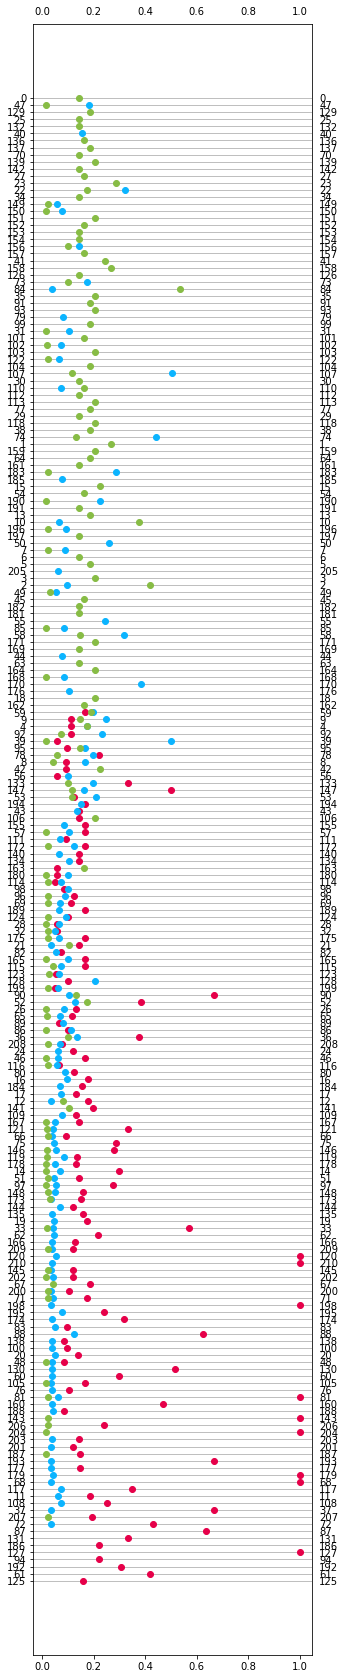

In [34]:
# Plot error bar
colors = ['#e60049', '#0bb4ff', '#87bc45']
plt.figure(figsize=(5,30))
plt.errorbar(a.Concentradas, a.name,  fmt = 'o',color = '#e60049', label=a.name,
            elinewidth = 2, capsize=10)
plt.errorbar(a.Medianas,a.name, fmt = 'o',color = '#0bb4ff', 
            ecolor = 'blue', elinewidth = 5, capsize=10, label=a.name)
plt.errorbar(a.Dispersas,a.name,fmt = 'o',color = '#87bc45', 
            ecolor = 'red', elinewidth = 5, capsize=10, label=a.name)
plt.yticks(a.name)
plt.grid(axis="y")
plt.tick_params(labelright=True, labeltop=True)
plt.show()

## FIN

In [35]:
test = bip_network.vs.select(typen=0)
bip_network.vs["cluster"] = -1
bip_network.vs["tipoC"] = -1

for user_ in test: # Loop over users in bipartite network
    # Find their node in user_network
    node_user_net = user_network.vs.find(name=user_["name"])
    user_["cluster"] = node_user_net["commty"]
    user_["tipoC"] = node_user_net["tipoCom"]

list(bip_network.vs())


[igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 0, {'name': 101, 'typen': 0, 'cluster': '0', 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 1, {'name': 202, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 2, {'name': 2101, 'typen': 0, 'cluster': '0', 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 3, {'name': 2202, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 4, {'name': 3101, 'typen': 0, 'cluster': '1', 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 5, {'name': 3202, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 6, {'name': 7101, 'typen': 0, 'cluster': '0', 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 7, {'name': 7202, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f90a55d50>, 8, {'name': 10101,

In [70]:
# Export Bip network with clusters id
ig.write(bip_network, "bip_with_dataHC.graphml")

In [36]:
user_attr

['role', 'specialty', 'team', 'uward', 'agentfor']

In [37]:
copy_bip = bip_network.copy()
test = copy_bip.vs.select(typen=0)

for user_ in test: # Loop over users in bipartite network
    # Find their node in user_network
    #node_user_net = user_network.vs.find(name=user_["name"])
    data_user = user_dict[user_["name"]]
    user_[user_attr[0]] = data_user[0]
    user_[user_attr[1]] = data_user[1]
    user_[user_attr[2]] = data_user[2]
    user_[user_attr[3]] = data_user[3]
    user_[user_attr[4]] = data_user[4]
    #user_["cluster"] = node_user_net["cluster"]
    #user_["tipoC"] = node_user_net["tipoCom"]

list(copy_bip.vs())


[igraph.Vertex(<igraph.Graph object at 0x7f4f8f7f6b50>, 0, {'name': 101, 'typen': 0, 'cluster': '0', 'tipoC': 0, 'role': 10, 'specialty': 111, 'team': 1111, 'uward': 11211, 'agentfor': 111211}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f8f7f6b50>, 1, {'name': 202, 'typen': 1, 'cluster': -1, 'tipoC': -1, 'role': None, 'specialty': None, 'team': None, 'uward': None, 'agentfor': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f8f7f6b50>, 2, {'name': 2101, 'typen': 0, 'cluster': '0', 'tipoC': 0, 'role': 11, 'specialty': 111, 'team': 1111, 'uward': 11111, 'agentfor': 111011}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f8f7f6b50>, 3, {'name': 2202, 'typen': 1, 'cluster': -1, 'tipoC': -1, 'role': None, 'specialty': None, 'team': None, 'uward': None, 'agentfor': None}),
 igraph.Vertex(<igraph.Graph object at 0x7f4f8f7f6b50>, 4, {'name': 3101, 'typen': 0, 'cluster': '1', 'tipoC': 0, 'role': 10, 'specialty': 113, 'team': 1121, 'uward': 11011, 'agentfor': 111111}),
 igraph.Vertex(<igraph

In [43]:
role = []
specialty = []
team = []
uward = []
agentfor = []
atrs_list = ['role', 'specialty', 'team', 'uward', 'agentfor']

for i in list(range(len(dict_commts))):
    #print(i)
    users_commty = copy_bip.vs.select(cluster=str(i))
    for atr in atrs_list:
    # Get the counter of values of an attribute
        valores_difd = Counter(users_commty[atr]).values()
        contador = max(valores_difd) / len(users_commty[atr])
        if atr == "role":
            role.append(contador)

        elif atr == "specialty":
            specialty.append(contador)

        elif atr == "team":
            team.append(contador)

        elif atr == "uward":
            uward.append(contador)

        elif atr == "agentfor":
            agentfor.append(contador)



    #print(len(users_commty["MGR_ID"]))
    #print(len(set(users_commty["MGR_ID"])))    

In [39]:
n_coms = len(dict_commts)
n_coms

39

<Figure size 432x288 with 0 Axes>

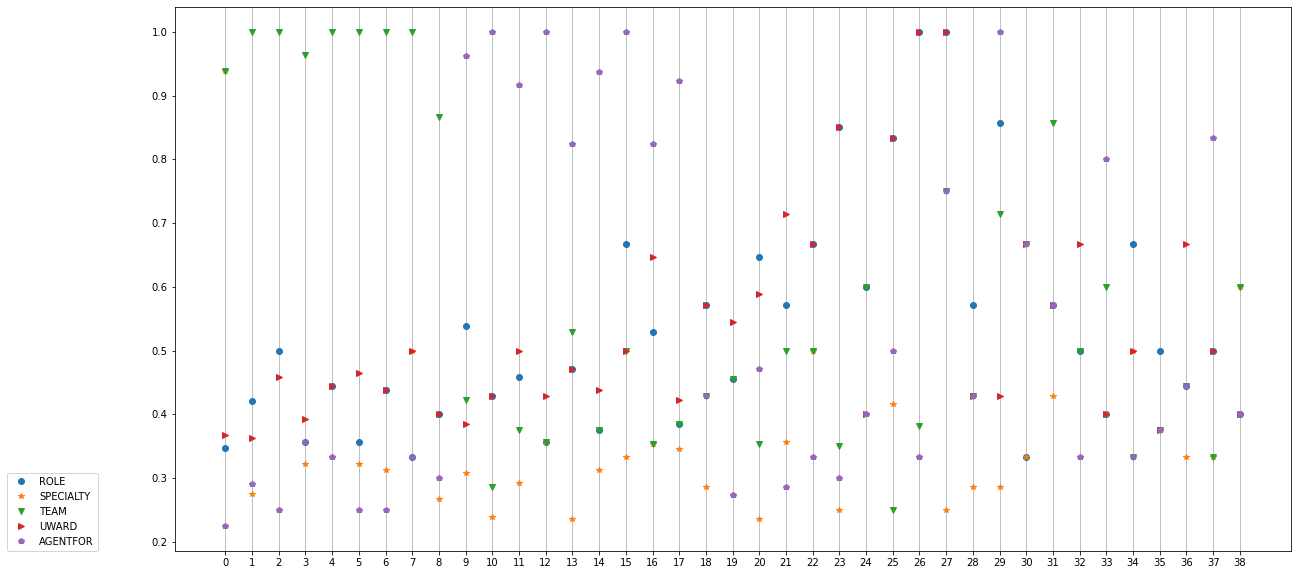

In [45]:
plt.clf()

plt.figure(figsize=(20,10))
plt.xticks(range(n_coms))
line_style = ""
plt.plot(range(n_coms), role, marker = 'o', ls=line_style, label="ROLE")
plt.plot( range(n_coms),specialty,marker = '*', ls=line_style, label="SPECIALTY")
plt.plot(range(n_coms), team, marker = 'v', ls=line_style,  label="TEAM")
plt.plot(range(n_coms), uward, marker = '>', ls=line_style, label="UWARD")
plt.plot(range(n_coms), agentfor, marker = 'p', ls=line_style, label="AGENTFOR")
plt.legend(loc=(-0.15, 0))

plt.grid(axis="x")

plt.show()

# LINEAR SCALE

#axs[0, 0].set_title('Linear Scale')
#axs[0, 0].plot(degree_list, color='#e60049')
#axs[0, 0].set(ylabel='P(k)', xlabel='k')


In [53]:
all_user_df = df_train_k_pos[df_train_k_pos.USRID.isin(bip_network.vs.select(typen=0)["name"])].drop_duplicates()

all_user_df = all_user_df.drop(columns=["RESID", "oward","type", "treatingteam", "patient","author","topic" ]).drop_duplicates()

#all_user_df = all_user_df[user_attrs].drop_duplicates().values.tolist()
len(all_user_df)

612

In [54]:
all_user_df

,role,uward,team,specialty,agentfor,USRID
1745,10,11211,1111,111,111211,101
7575,11,11111,1111,111,111011,2101
8573,10,11011,1121,113,111111,3101
7716,11,11111,1111,111,111111,7101
7612,10,11211,1121,114,111211,10101
...,...,...,...,...,...,...
182,12,11011,1101,111,111111,366101
3991,12,11111,1101,113,111411,479101
8510,11,11011,1121,110,111411,600101
7054,10,11111,1131,111,111211,997101


In [55]:
import kmodes
###Select the number of clusters###
num_clusters = n_coms

#DO NOT CHANGE THIS CODE
#seed = 29
#Compute centroids and labels
num_init = 5
centroids = []
kmodes_huang = kmodes.KModes(n_clusters=num_clusters, n_init=num_init, init='Huang', verbose=0) #, random_state=seed)
cluster_labels = kmodes_huang.fit_predict(all_user_df)
centroids = kmodes_huang.cluster_centroids_

print('Ready!')    

Ready!


In [57]:
new_user_df = pd.DataFrame(all_user_df)
new_user_df.columns = atrs_list + ["USRID"]
new_user_df["cluster"] = cluster_labels
new_user_df

,role,specialty,team,uward,agentfor,USRID,cluster
1745,10,11211,1111,111,111211,101,1
7575,11,11111,1111,111,111011,2101,1
8573,10,11011,1121,113,111111,3101,10
7716,11,11111,1111,111,111111,7101,1
7612,10,11211,1121,114,111211,10101,16
...,...,...,...,...,...,...,...
182,12,11011,1101,111,111111,366101,18
3991,12,11111,1101,113,111411,479101,0
8510,11,11011,1121,110,111411,600101,5
7054,10,11111,1131,111,111211,997101,9


In [59]:
role = []
specialty = []
team = []
uward = []
agentfor = []
atrs_list = ['role', 'specialty', 'team', 'uward', 'agentfor']

for i in list(range(n_coms)):
    #print(i)
    a = new_user_df[new_user_df.cluster==i]
    for atr in atrs_list:
    # Get the counter of values of an attribute
        valores_difd = Counter(a[atr]).values()
        contador = max(valores_difd) / len(a[atr])
        if atr == "role":
            role.append(contador)

        elif atr == "specialty":
            specialty.append(contador)

        elif atr == "team":
            team.append(contador)

        elif atr == "uward":
            uward.append(contador)

        elif atr == "agentfor":
            agentfor.append(contador)



    #print(len(users_commty["MGR_ID"]))
    #print(len(set(users_commty["MGR_ID"])))    

<Figure size 432x288 with 0 Axes>

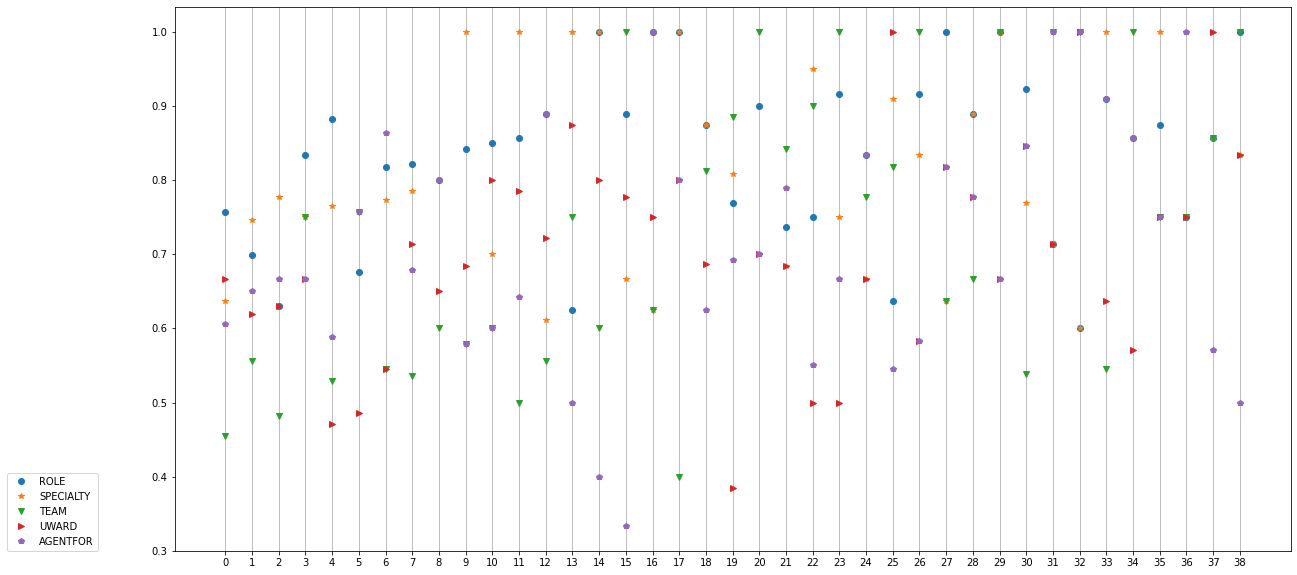

In [60]:
plt.clf()

plt.figure(figsize=(20,10))
plt.xticks(range(n_coms))
line_style = ""
plt.plot(range(n_coms), role, marker = 'o', ls=line_style, label="ROLE")
plt.plot( range(n_coms),specialty,marker = '*', ls=line_style, label="SPECIALTY")
plt.plot(range(n_coms), team, marker = 'v', ls=line_style,  label="TEAM")
plt.plot(range(n_coms), uward, marker = '>', ls=line_style, label="UWARD")
plt.plot(range(n_coms), agentfor, marker = 'p', ls=line_style, label="AGENTFOR")
plt.legend(loc=(-0.15, 0))

plt.grid(axis="x")

plt.show()

# LINEAR SCALE

#axs[0, 0].set_title('Linear Scale')
#axs[0, 0].plot(degree_list, color='#e60049')
#axs[0, 0].set(ylabel='P(k)', xlabel='k')


In [62]:
lista_accesos_rec_cluster = []

for i in range(n_coms):
    #print(i)
    a = new_user_df[new_user_df.cluster==i]
    a = list(a["USRID"])
    a = df_train_k_pos[df_train_k_pos.USRID.isin(a)]
    a = set(list(a["RESID"]))
    #print(len(a))
    lista_accesos_rec_cluster.append(len(a))    
    #print(len(users_commty["MGR_ID"]))
    #print(len(set(users_commty["MGR_ID"])))    
len(lista_accesos_rec_cluster)

39

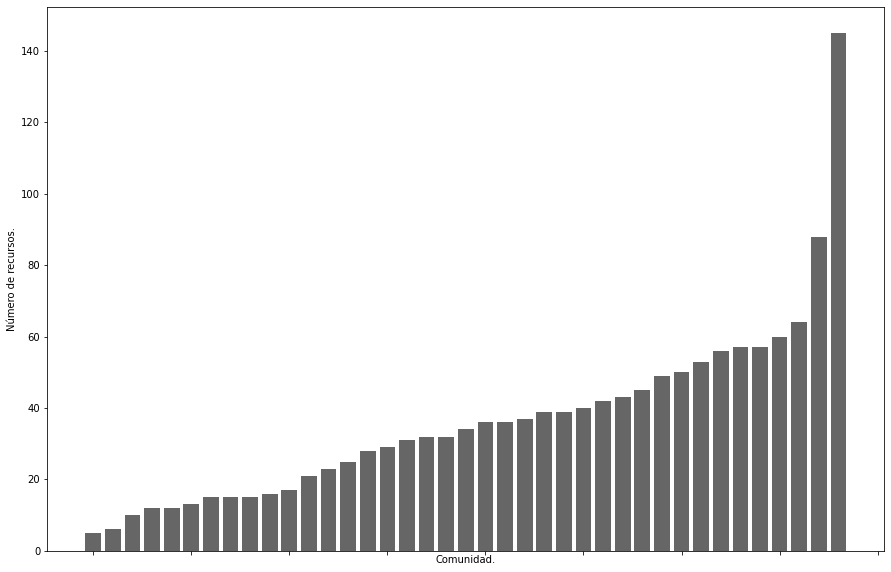

In [63]:
plt.figure(figsize=(15,10))
plt.bar(range(n_coms), sorted(lista_accesos_rec_cluster, reverse=False), color='0.40')
#plt.plot(range(n_coms), comulative_res[1:])
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
plt.show()
#plt.savefig('n_recursos_por_comunidad_amz.pdf')

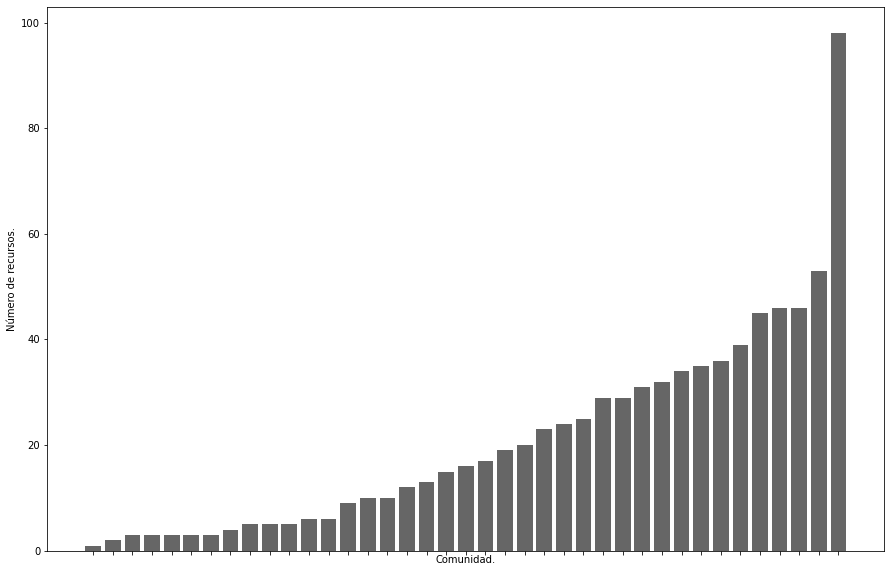

In [64]:
plt.figure(figsize=(15,10))
plt.bar(dict_commts.keys(), sorted(n_res_in_comms, reverse=False), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
plt.show()
#plt.savefig('n_recursos_por_comunidad_amz.pdf')

## CHanges commts

In [6]:
### Get id commts

nodes_belong_commts = {}
# { 1: {1: [a,b,c], 2: [1,2,3] }, 2: {}, 3: {}}
for i in user_network.vs:
    nodes_belong_commts[i["name"]] = {}

for i in range(5):
    
        ## Community detection algorithm
    user_network_i = user_network.copy()

    # Louvain Algorithm
    partition = user_network_i.community_multilevel(weights=user_network_i.es()["weight"])
    #print("Modularity: %.4f" % partition.modularity) # Modualarity value

    # Add cluster attribute to nodes
    user_network_i.vs["commty"] = partition.membership
    #print(partition.summary())

    dict_commts = sub_community_detection(user_network_i, partition, 0.5)

    #print(user_network.summary())
    #print("# Commts", len(dict_commts))

    for user_node in user_network_i.vs:
        # Seleccionar su comunidad
        user_commty = user_node["commty"]

        # Selecionar todos los nodos de la comunidad
        users_commty_in = user_network_i.vs.select(commty=user_commty)

        # Guardarlo en su diccionario
        nodes_belong_commts[user_node["name"]][i] = users_commty_in["name"]
        

In [7]:
x_commty_value = {}
for key_, value_ in nodes_belong_commts.items():
    intersection_ = {}
    union_ = {}
    for key__, value__ in value_.items():
        if key__ == 0:
            intersection_ = set(value__)
            union_ = set(value__)
        else:
            intersection_ = intersection_.intersection(set(value__))
            union_ = union_.union(set(value__))
    x_commty_value[key_] = len(intersection_) / len(union_)
    #print(x_commty_value)
    

In [8]:
user_network.vs["change"] = list(x_commty_value.values())

In [9]:
test = bip_network.vs.select(typen=0)
bip_network.vs["change"] = -1

for user_ in test: # Loop over users in bipartite network
    # Find their node in user_network
    try:
        node_user_net = user_network.vs.find(name=user_["name"])
    except:
        continue
    
    user_["change"] = node_user_net["change"]    

len(list(bip_network.vs()))


823

In [10]:
bip_network.write("new_changesHC.graphml", format="graphml")

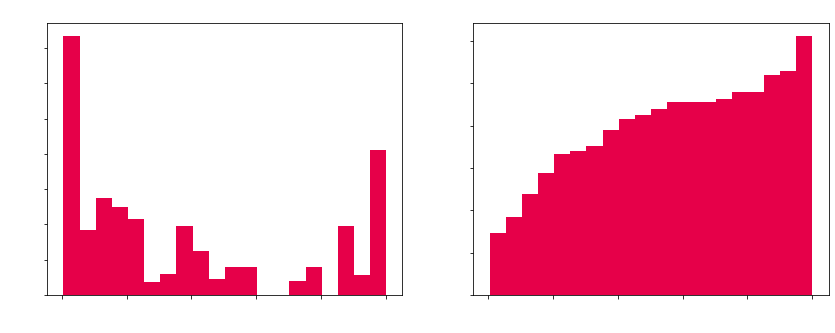

In [13]:
### Density distribution of each community

density_distribution= user_network.vs["change"]

fig, axs = plt.subplots(1, 2, figsize=(14,5))

counts, bins = np.histogram(density_distribution, 20)

# Density distribution
axs[0].set_title('RC distribution', color="w")
axs[0].hist(bins[:-1], bins, weights=counts, color="#e60049")
axs[0].set_xlabel("Razón de Cambio", color="w")
axs[0].set_ylabel("# Nodos", color="w")

axs[1].set_title('RC distribution comulative', color="w")
axs[1].hist(bins[:-1], bins, weights=counts, color="#e60049", cumulative=True,
            histtype="bar")

axs[1].set_xlabel("Razón de Cambio", color="w")
axs[1].set_ylabel("# Nodos", color="w")
plt.setp(axs[1].get_xticklabels(), color="w")
plt.setp(axs[0].get_xticklabels(), color="w")
plt.setp(axs[1].get_yticklabels(), color="w")
plt.setp(axs[0].get_yticklabels(), color="w")

plt.show()

plt.show()

In [16]:
print(len(bip_network.vs.select(typen=0)))


612

In [18]:
len(bip_network.vs.select(typen=1))

211